In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [7]:
from utils import gen_data, gen_covariance, sparsify_beta, gen_beta2

In [8]:
root_dir = '/mnt/sdb1'

In [9]:
lasso = pd.read_pickle('%s/finalfinal/lasso_concat_df.dat' % root_dir)
mcp = pd.read_pickle('%s/finalfinal/mcp_concat_df.dat' % root_dir)
scad = pd.read_pickle('%s/finalfinal/scad_concat_df.dat' % root_dir)
en = pd.read_pickle('%s/finalfinal/en_concat_df.dat' % root_dir)

In [10]:
from plotting_utils import *
import h5py

In [11]:
import pickle

In [15]:
sparsity = np.unique(lasso['sparsity'].values)

### Calculation and initial plotting

In [ ]:
# Load all covariance matrices and cov_params into memory to save time

In [20]:
pregen_cov_params = [] 
for cov_idx in np.arange(120):
    sigma, cp = load_covariance(cov_idx)
    pregen_cov_params.append((sigma, cp))

In [30]:
def calc_eta_sa(cov_indices, df, flag, threshold=1):
    t0 = time.time()
    eta = np.zeros(len(cov_indices))    
    sa = np.zeros(len(cov_indices))
    for i, cov_idx in enumerate(cov_indices):
        sigma, cov_param = pregen_cov_params[cov_idx]
        df_ = apply_df_filters(df, cov_idx=cov_idx)                
        # take the minimum non-zero beta value - magnitudes don't matter
        beta = np.ones(df_.iloc[0]['n_features'])               
        # Sparsify beta
        beta = sparsify_beta(beta[:, np.newaxis], cov_param['block_size'], df_.iloc[0]['sparsity'],
                             seed = cov_param['block_size'])
        beta = beta.ravel()
        k = np.nonzero(beta)[0]
        if len(k) > 0 and len(k) < beta.size:                    
            # For each seed in df_, generate data accordingly and use the empirical covariance to calculate
            # eta
            eta_ = np.zeros(df_.shape[0])
            for j in range(df_.shape[0]):
                _df_ = df_.iloc[j]
                np.random.seed(int(_df_['seed']))
                X = np.random.multivariate_normal(mean = np.zeros(_df_['n_features']), cov=sigma, 
                                                  size=_df_['np_ratio'] * _df_['n_features'])
                sigma_hat = X.T @ X
                eta_[j] = calc_irrep_const(sigma_hat, k)
                
            eta[i] = np.nanmean(eta_)
        else:
            eta[i] = np.nan

        # Just return the average selection accuracy
        if flag is None:
            sa[i] = np.mean(df_['sa'].values)

        if flag == 'threshold':
            sa[i] = np.count_nonzero(1 * df_['sa'].values > threshold)/len(cov_indices[i])
    
    return eta, sa

In [31]:
np_ratio = 4
kappa = 5
betawidth = [np.inf]
selection_methods = np.unique(lasso['selection_method'])
dframes = [lasso, mcp, scad, en]
#dframes = [uoi, en]
dframe_names = ['Lasso', 'MCP', 'SCAD', 'EN']

# Need to create a dataframe 
eta_datalist = []

for i, dframe in enumerate(dframes):                
    for j, bw in enumerate(betawidth):
        t0 = time.time() 
        for h, sm in enumerate(selection_methods):
            for k, s in enumerate(sparsity):            
                t0 = time.time()
                df = apply_df_filters(dframe, kappa=kappa, np_ratio=np_ratio, selection_method=sm,
                                      betawidth=bw, sparsity=s)
                cov_indices = np.unique(df['cov_idx'].values) 
                
                
                eta_, sa_ = calc_eta_sa(cov_indices, df, flag=None)
                eta_datalist.append({'df_name' : dframe_names[i], 'betawidth': bw, 'sparsity' : s,
                                       'eta': eta_, 'sa': sa_, 'selection_method': sm})       
                print(time.time() - t0)
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

147.7410991191864
157.30582857131958


KeyboardInterrupt: 

### Plotting

#### First set of plots: one for each of the selection methods

In [45]:
alpha_datalist = pd.DataFrame(alpha_datalist)

In [46]:
list(alpha_datalist.keys())

['df_name', 'betawidth', 'sparsity', 'alpha', 'sa', 'selection_method']

In [58]:
from collections import OrderedDict

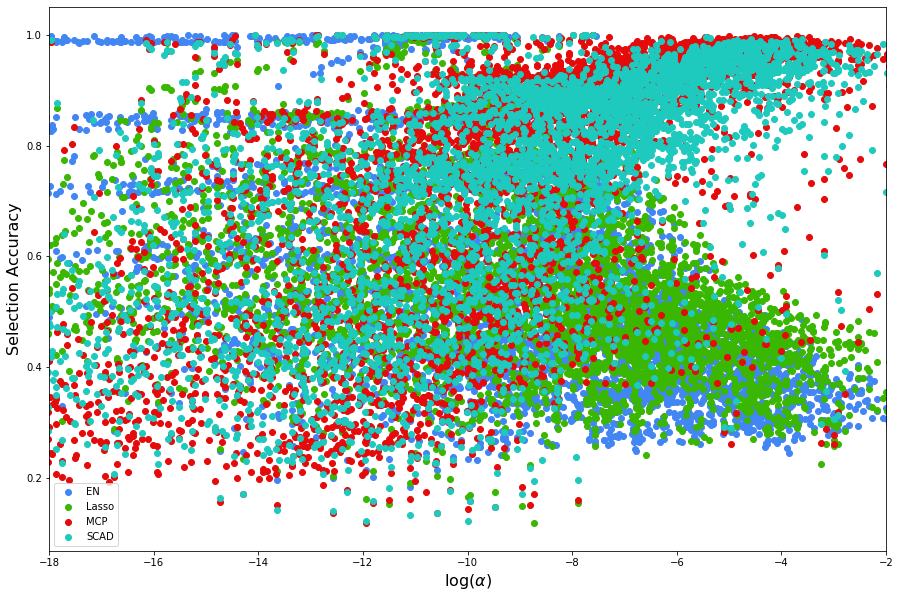

In [62]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
selection_method = 'CV'
dframe_names = np.unique(alpha_datalist['df_name'].values)

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
pal_colors = cols

fig, ax = plt.subplots(figsize=(15, 10))

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

for i, dframe in enumerate(dframe_names):        
    rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method)
    for j in range(rows.shape[0]):
         ax.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['sa'], label=rows.iloc[j]['df_name'],
                    color=cols[list(dframe_names).index(rows.iloc[j]['df_name'])])    

ax.set_xlim([-18, -2])
ax.set_ylabel('Selection Accuracy', fontsize=16)
ax.set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

In [72]:
np.unique(alpha_datalist['betawidth'].values)

array([-1. ,  0.1,  inf])

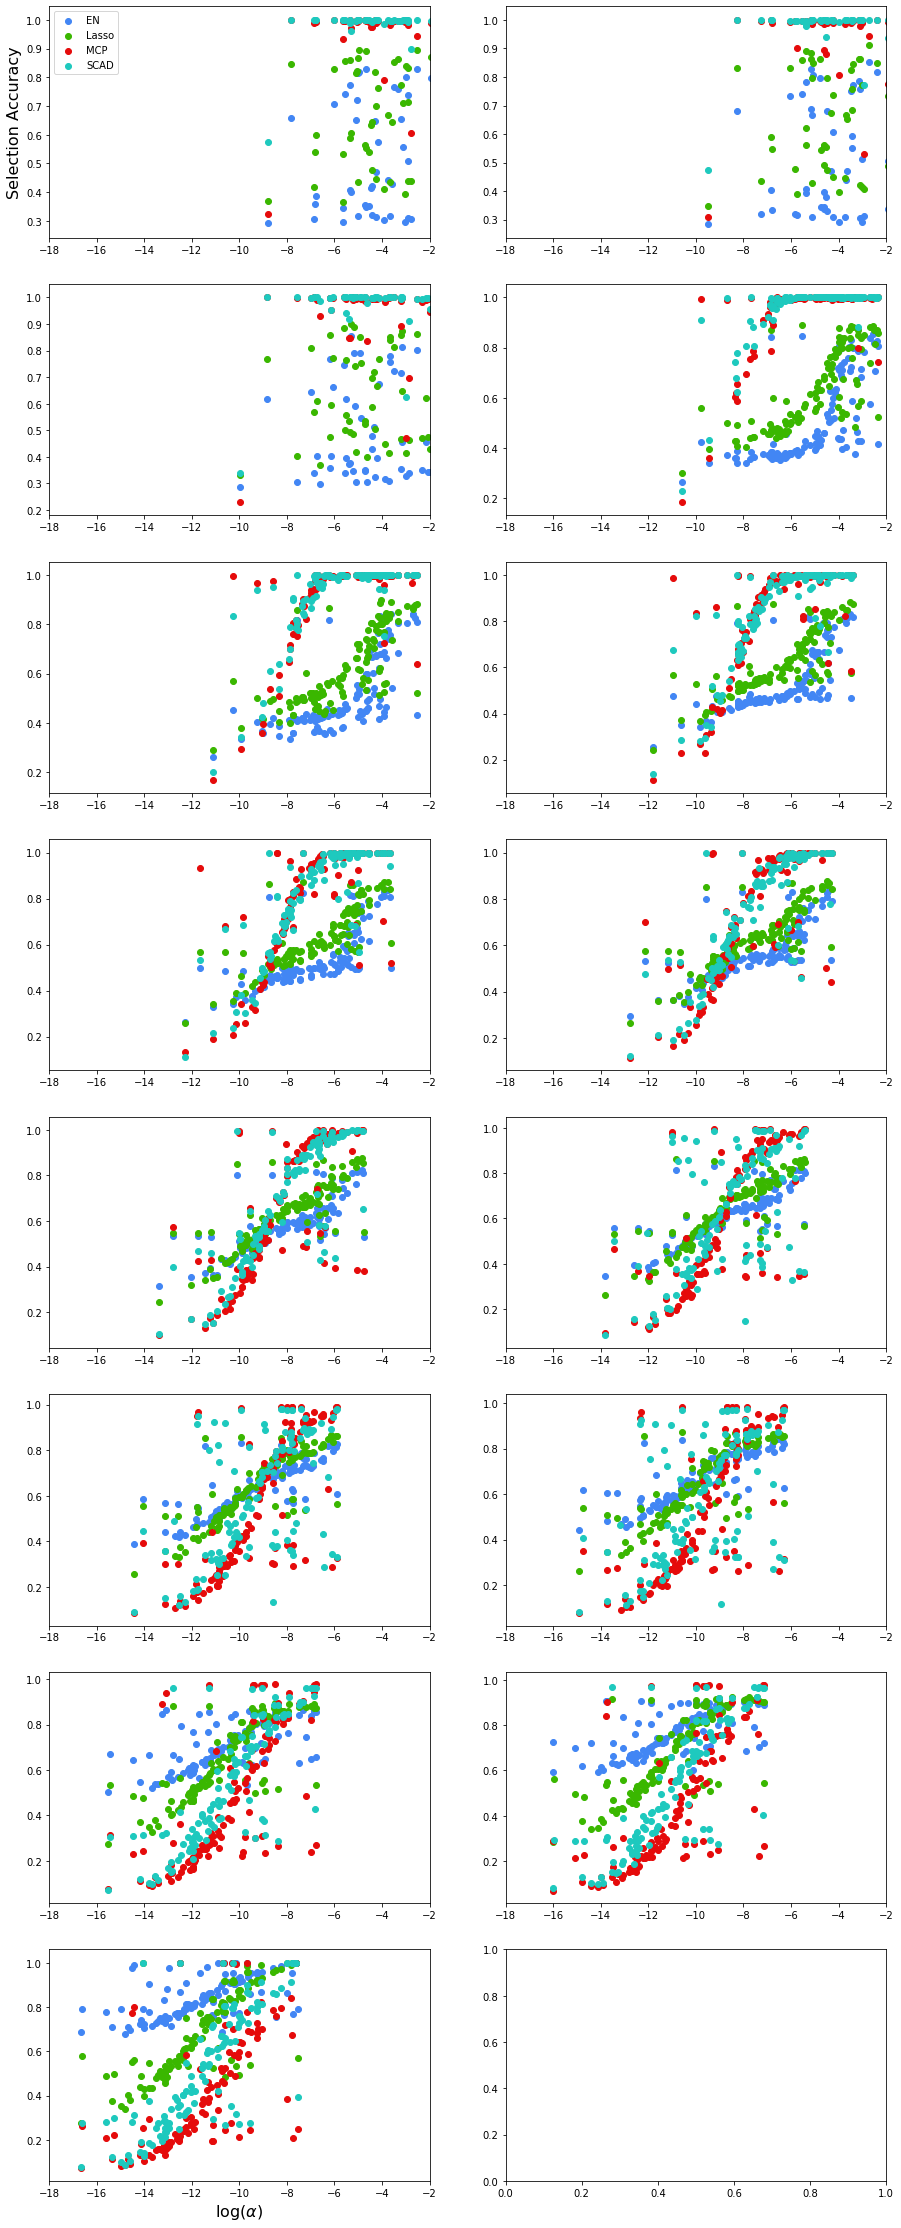

In [73]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
selection_method = 'BIC'
dframe_names = np.unique(alpha_datalist['df_name'].values)

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(8, 2, figsize=(15, 40))

for h, s in enumerate(sparsity):
    a = ax[np.unravel_index(h, (8,2))]
    for i, dframe in enumerate(dframe_names):        
        rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                sparsity=s, betawidth=0.1)
        for j in range(rows.shape[0]):
             a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['sa'], label=rows.iloc[j]['df_name'],
                        color=cols[list(dframe_names).index(rows.iloc[j]['df_name'])])    
    a.set_xlim([-18, -2])

ax[0, 0].set_ylabel('Selection Accuracy', fontsize=16)
ax[7, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

In [ ]:
# Eta calculations